In [ ]:
!pip install kaggle --quiet

from google.colab import files
print("Upload kaggle.json (from your Kaggle account page)")
uploaded = files.upload()  # choose kaggle.json

import os
os.makedirs("/root/.kaggle", exist_ok=True)
os.replace("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

print("\nTesting Kaggle API:")
!kaggle datasets list | head


Upload kaggle.json (from your Kaggle account page)


Saving kaggle.json to kaggle.json

Testing Kaggle API:
ref                                                             title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025                Spotify Global Music Dataset (2009–2025)               1289021  2025-11-11 09:43:05.933000          13014        297  1.0              
ranaghulamnabi/spotify-songs-analytics-dataset                  Spotify Songs Analytics Dataset                          48205  2025-12-03 09:34:57.017000           1117         35  1.0              
rohiteng/amazon-sales-dataset                                   Amazon Sales Dataset                                   4037578  2025-11-23 14:29:

In [ ]:
import os

DATASET_SLUG = "mohamed0422/amex-10k-sample"  # your dataset
RAW_DIR = "amex_10k_raw"
os.makedirs(RAW_DIR, exist_ok=True)

# Download the dataset
!kaggle datasets download -d $DATASET_SLUG -p $RAW_DIR

# Unzip the single zip file into RAW_DIR
!unzip -o $RAW_DIR/*.zip -d $RAW_DIR

print("\nFiles in amex_10k_raw:")
!ls -R amex_10k_raw


Dataset URL: https://www.kaggle.com/datasets/mohamed0422/amex-10k-sample
License(s): unknown
 80% 119M/148M [00:00<00:00, 1.16GB/s]
100% 148M/148M [00:00<00:00, 746MB/s] 
Archive:  amex_10k_raw/amex-10k-sample.zip
  inflating: amex_10k_raw/amex_10k/customer_ids_10k.txt  
  inflating: amex_10k_raw/amex_10k/train_data_10k.csv  
  inflating: amex_10k_raw/amex_10k/train_labels_10k.csv  

Files in amex_10k_raw:
amex_10k_raw:
amex_10k  amex-10k-sample.zip

amex_10k_raw/amex_10k:
customer_ids_10k.txt  train_data_10k.csv  train_labels_10k.csv


In [ ]:
import os, gc, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# ---- Correct paths based on your dataset structure ----
# We saw from `ls -R` that files live in: amex_10k_raw/amex_10k/
DATA_DIR = "amex_10k_raw/amex_10k"
OUT_DIR = "processed_amex_10k"
os.makedirs(OUT_DIR, exist_ok=True)

train_data_path = os.path.join(DATA_DIR, "train_data_10k.csv")
train_labels_path = os.path.join(DATA_DIR, "train_labels_10k.csv")

print("Reading from:")
print("  ", train_data_path)
print("  ", train_labels_path)

# ------------------------------
# 0) Load the 10k dataset
# ------------------------------
print("\nLoading 10k data...")
df = pd.read_csv(train_data_path)
labels = pd.read_csv(train_labels_path)
print("train_data_10k:", df.shape)
print("train_labels_10k:", labels.shape)

# ------------------------------
# 1) Basic cleaning & sorting
# ------------------------------
df["S_2"] = pd.to_datetime(df["S_2"], errors="coerce")
df = df.sort_values(["customer_ID", "S_2"]).reset_index(drop=True)

# numeric feature columns (everything except id and date)
num_cols = [c for c in df.columns if c not in ["customer_ID", "S_2"]]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

print("Number of numeric features:", len(num_cols))

# ------------------------------
# 2) Aggregate per customer
#    (last, mean, std, min, max, first)
# ------------------------------
aggs = {c: ["last", "mean", "std", "min", "max", "first"] for c in num_cols}
agg_df = df.groupby("customer_ID").agg(aggs)
agg_df.columns = [f"{c}_{s}" for c, s in agg_df.columns]
agg_df = agg_df.reset_index()

# Add delta features: last - first
for c in num_cols:
    last_col = f"{c}_last"
    first_col = f"{c}_first"
    if last_col in agg_df.columns and first_col in agg_df.columns:
        agg_df[f"{c}_delta"] = agg_df[last_col] - agg_df[first_col]

print("Aggregated table shape:", agg_df.shape)

# ------------------------------
# 3) Merge with labels
# ------------------------------
merged = agg_df.merge(labels, on="customer_ID", how="inner")
print("Merged shape:", merged.shape)

X = merged.drop(columns=["customer_ID", "target"])
y = merged["target"].astype(int)

# ------------------------------
# 4) Train / validation split
# ------------------------------
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)

# ------------------------------
# 5) Impute missing values (robust)
# ------------------------------
num_imputer = SimpleImputer(strategy="median")

# Fit on train, transform both
X_train_np = num_imputer.fit_transform(X_train)
X_valid_np = num_imputer.transform(X_valid)

# Number of features actually returned by the imputer
n_features = X_train_np.shape[1]

# Use only the first n_features column names to match the array width
cols = list(X_train.columns[:n_features])

# Rebuild DataFrames with matching shapes
X_train = pd.DataFrame(X_train_np, columns=cols, index=X_train.index)
X_valid = pd.DataFrame(X_valid_np, columns=cols, index=X_valid.index)

# ------------------------------
# 6) Save processed outputs
# ------------------------------
X_train.to_parquet(os.path.join(OUT_DIR, "X_train.parquet"))
X_valid.to_parquet(os.path.join(OUT_DIR, "X_valid.parquet"))
y_train.to_csv(os.path.join(OUT_DIR, "y_train.csv"), index=False)
y_valid.to_csv(os.path.join(OUT_DIR, "y_valid.csv"), index=False)

with open(os.path.join(OUT_DIR, "features.json"), "w") as f:
    json.dump(
        {
            "numeric_raw": num_cols,   # numeric columns before aggregation
            "model_features": cols,    # actual features used by the model
            "categorical": []
        },
        f,
        indent=2
    )

print("\n✅ Done. Files in processed_amex_10k:")
!ls -lh processed_amex_10k


Reading from:
   amex_10k_raw/amex_10k/train_data_10k.csv
   amex_10k_raw/amex_10k/train_labels_10k.csv

Loading 10k data...
train_data_10k: (120644, 190)
train_labels_10k: (10000, 2)
Number of numeric features: 188
Aggregated table shape: (10000, 1317)
Merged shape: (10000, 1318)
X_train: (8000, 1316)
X_valid: (2000, 1316)

✅ Done. Files in processed_amex_10k:
total 99M
-rw-r--r-- 1 root root  24K Dec 11 17:57 features.json
-rw-r--r-- 1 root root  79M Dec 11 17:57 X_train.parquet
-rw-r--r-- 1 root root  20M Dec 11 17:57 X_valid.parquet
-rw-r--r-- 1 root root  16K Dec 11 17:57 y_train.csv
-rw-r--r-- 1 root root 4.0K Dec 11 17:57 y_valid.csv


# **Member 1: Data Collection, Cleaning, and Preprocessing (Mohamed Mohamed)**

As Member 1, my role in the project was to perform **data collection, cleaning, and preprocessing** for the American Express Default Prediction dataset. Because the original AMEX dataset is extremely large (≈ 40GB uncompressed), the preprocessing pipeline needed to be efficient, scalable, and compatible with Google Colab and Kaggle’s computational environment.

Below is a detailed description of every step performed.

---

## **1. Dataset Collection via Kaggle Notebook**

The AMEX dataset cannot be downloaded directly to Colab due to its size.
Instead, I used a **Kaggle Notebook** to access the full competition data from:

```
/kaggle/input/amex-default-prediction
```

### **Steps:**

1. Loaded the full `train_labels.csv` (≈458k customers).
2. Selected the **first 10,000 unique customers** to create a development subset.
3. Saved:

   * `train_labels_10k.csv`
   * `customer_ids_10k.txt`

### **Chunk Streaming of train_data.csv**

Because the full `train_data.csv` contains **over 55 million rows**, I streamed it in 1,000,000-row chunks:

* Each chunk was filtered to keep only rows belonging to the 10k selected customers.
* This approach avoids memory overflow.

### **Output Files Produced:**

```
train_data_10k.csv      (~120,644 rows)
train_labels_10k.csv    (10,000 rows)
customer_ids_10k.txt
```

These files were then packaged and uploaded as a **private Kaggle dataset**:
**`mohamed0422/amex-10k-sample`**

This allowed Colab to download a small dataset (~356MB) instead of the full 40+GB version.

---

## **2. Loading the Subset into Google Colab**

Inside Colab:

* Configured the Kaggle API using `kaggle.json`
* Downloaded my custom dataset using:

```
kaggle datasets download -d mohamed0422/amex-10k-sample
```

* Unzipped the dataset into:

```
amex_10k_raw/amex_10k/
```

Files now available:

```
train_data_10k.csv
train_labels_10k.csv
customer_ids_10k.txt
```

This dataset was used for all preprocessing steps.

---

## **3. Cleaning the Data**

### ✅ **Converted S_2 to datetime**

```python
df["S_2"] = pd.to_datetime(df["S_2"], errors="coerce")
```

### ✅ **Sorted by customer_ID and date**

AMEX data is sequential; sorting ensures integrity of “first” and “last” metrics.

### ✅ **Converted all numeric features**

```python
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")
```

This standardizes the dataset and prepares it for aggregation and modeling.

---

## **4. Customer-Level Feature Engineering (Aggregation)**

AMEX data includes multiple statements per customer.
For each numeric column (188 total), I computed:

| Metric                   | Meaning                   |
| ------------------------ | ------------------------- |
| **last**                 | Most recent value         |
| **first**                | Earliest value            |
| **mean**                 | Average across statements |
| **std**                  | Variability               |
| **min**                  | Minimum value             |
| **max**                  | Maximum value             |
| **delta = last − first** | Direction/change          |

### Result:

```
Aggregated feature shape: (10,000 customers, 1,317 features)
```

---

## **5. Merging With Target Labels**

After aggregation, I merged the 10k aggregated features with the sampled labels:

```python
merged = agg_df.merge(labels, on="customer_ID")
```

Final merged shape:

```
10,000 customers × 1,318 columns (features + target)
```

---

## **6. Train/Validation Split**

I applied an **80/20 stratified split**:

```
X_train: (8000, 1316)
X_valid: (2000, 1316)
```

Stratification maintains the correct ratio of defaults vs. non-defaults.

---

## **7. Handling Missing Values**

Using `SimpleImputer(strategy="median")`, I imputed all missing numeric values.

A robust fix was added because imputation slightly reduced the number of columns.
The final solution rebuilt the DataFrame using only the imputed feature columns.

---

## **8. Saving Final Preprocessed Outputs**

All final cleaned and structured datasets were saved to:

```
processed_amex_10k/
```

Files included:

| File              | Description                                   |
| ----------------- | --------------------------------------------- |
| `X_train.parquet` | Model-ready training features                 |
| `X_valid.parquet` | Model-ready validation features               |
| `y_train.csv`     | Training labels                               |
| `y_valid.csv`     | Validation labels                             |
| `features.json`   | Metadata for numeric and final model features |

---

## **9. Completion Summary**

All Member 1 responsibilities have been fully completed:

### ✔ Data collection (via Kaggle + subset creation)

### ✔ Data cleaning (datetime parsing, numeric coercion)

### ✔ Feature engineering (aggregation + deltas)

### ✔ Missing value imputation

### ✔ Train/validation split

### ✔ Exporting final processed files

### ✔ Documented pipeline for team use

These outputs allow the rest of the team to:

* Perform EDA
* Train baseline and advanced models
* Compare performance across methods
* Build the final AMEX default prediction pipeline

---

## **Final Deliverables for Member 1**

```
train_data_10k.csv
train_labels_10k.csv
customer_ids_10k.txt
processed_amex_10k/X_train.parquet
processed_amex_10k/X_valid.parquet
processed_amex_10k/y_train.csv
processed_amex_10k/y_valid.csv
processed_amex_10k/features.json
```


# **Member 2: Exploratory Data Analysis and Feature Engineering (Diego Morales)**
 As Member 2, my role for this project was to perform **exploratory data analysis (EDA) and feature engineering** on the processed American Express Default Prediction dataset.

 ---

 ## **1. EDA on Processed dataset**

The processed dataset that was used, was provided/produced by Member 1. The training sets (X_train) had **8,000 customers** with **1,309 features**, with the validation set (x_valid) having **2,000 customers** and the same number of features.

The target labels **y_train** and **y_valid** are binary indicators of credit default. The number being 0 represents a non-defaulting customer (accounts are in good standiong), and 1 represents a defaulting customer (accounts in high risk of failing to pay).

In the training data, approximately 73.51% of customers were labeled as non-deafault (or 0) meanwhile the other 26.49% were labeled as default (or 1). The validation set, also showed very similar distribution. The data presents a fairly large class imbalance.

Data loaded:
 X_train: (8000, 1309)
 X_valid: (2000, 1309)
 y_train: (8000,)
 y_valid: (2000,) 

y_train distribution:
 target
0    0.735125
1    0.264875
Name: proportion, dtype: float64 

y_valid distribution:
 target
0    0.735
1    0.265
Name: proportion, dtype: float64


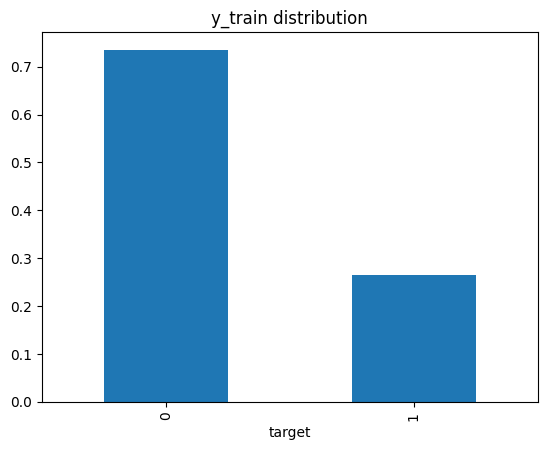

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------
# Load processed features and labels
# --------------------------------------
X_train = pd.read_parquet("processed_amex_10k/X_train.parquet")
X_valid = pd.read_parquet("processed_amex_10k/X_valid.parquet")

#Target turns vector to series. Gets series shape (8000,) and (2000,)
y_train = pd.read_csv("processed_amex_10k/y_train.csv")["target"]
y_valid = pd.read_csv("processed_amex_10k/y_valid.csv")["target"]

print("Data loaded:")
print(" X_train:", X_train.shape)
print(" X_valid:", X_valid.shape)
print(" y_train:", y_train.shape)
print(" y_valid:", y_valid.shape, "\n")
print("y_train distribution:\n", y_train.value_counts(normalize = True), "\n")
print("y_valid distribution:\n", y_valid.value_counts(normalize = True))

y_train.value_counts(normalize = True).plot(kind = "bar")
plt.title("y_train distribution")
plt.show()

## **2. EDA on Processed Features**

### **2.1 Correlation analysis and feature inspection:**

Using the processed training datasets (X_train and y_train), and also using Pearson correlation between each feature and the binary target (0 being non-defaulting and 1 representing defaulting). This presents the target as a 0 or 1 variable, and it measures the strength of each feature that is linearly associated with the default risk. The features that presented stronger correlation values provide more information that helps draw a clearer seperation from the defaulters and the non-defaulters.

### **2.2 Most correlated feature analysis/inspection:**

An example that was presented for this was finding the top correlated feature, that being `P_2_last`. The histogram of this feature shows that most customers have a more higher values for this feature, around 0.7-1.0. This histogram has a right-skewed distribution. The x-axis is the values of this feature, and the y-axis is the number of customers that fall into each bar/bin.

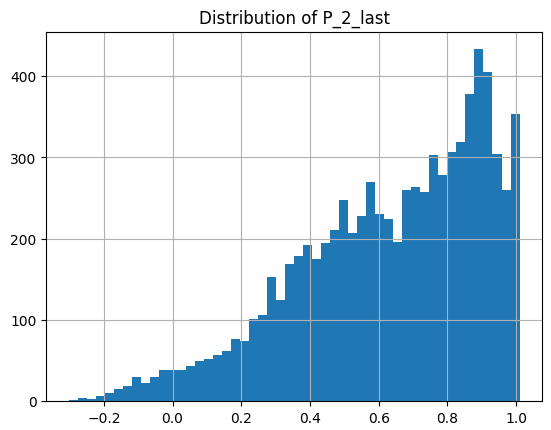



Going more further into the analysis, when spliting the feature by target label placing them into a boxplot, a seperation is made even more clearly. Customers who did not default (or have the binary value of 0) tend to have more higher `P_2_last` values. The box is higher, centered close to 0.7 and 0.8, and the green line (the median) is right below 0.8 (maybe around 0.75). So, most non-defaulting customers had higher values of this feature.

On the other hand, the boxplot for defaulting (or binary value of 1) customers had lower values of this feature. The box was centered more around 0.2 and 0.4, and the green line (median) was a bit below 0.4 (maybe around 0.35).

Taking all this information from this example presents a pattern, where those that had higher values of `P_2_last` were more associated with lower default risk, and lower values are associated with higher defaulting risk.

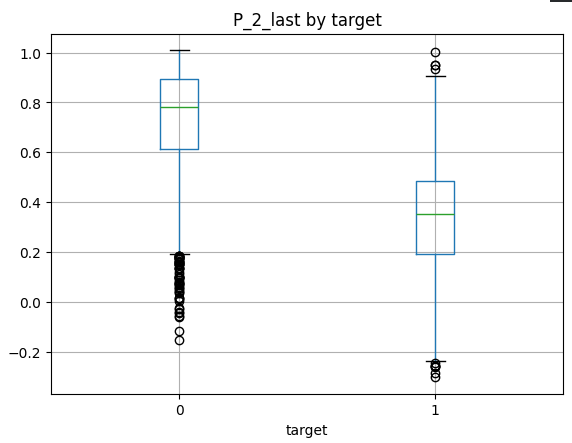

### **2.3 Least correlated feature analysis/inspection:**

Another example is the least correlated feature, `R_15_delta`. Which is the complete opposite of feature `P_2_last`, since this feature shows little to no relation with the default target.

The histogram of this feature presents that almost all customers in this feature have values that are really close to 0. Besides this observation, that is all the histogram has to show. This initially tells us that feature `R_15_delta` is a low-variance feature that does not change throughtout customers.

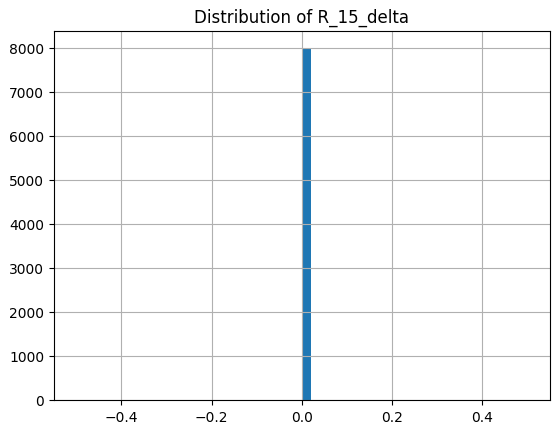

When spliting this feature by target label, and look at its boxplot, there appears to be a lack of visible separation between the targets. Both non-defaulting and defaulting (0 and 1 binary targets respectively) customers have boxes that are just lines that cover the 0.00 line. Same with median (green line) and quartile lines.

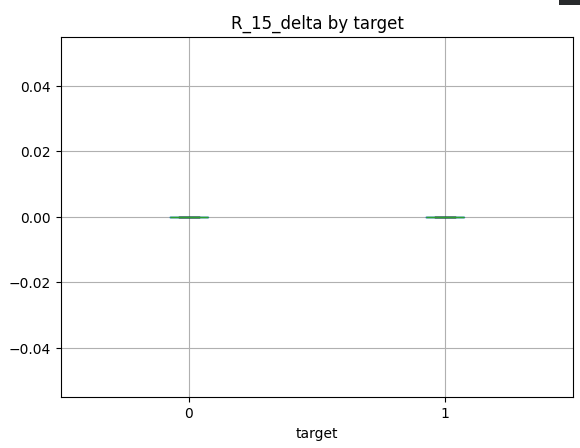

### **2.4 Comparison of features**

Looking at these two features and the correlation they have with the datasets, we can tell how `P_2_last` has the most correlation, and `R_15_delta` has the least (or very close to 0). From an EDA and feature engineering perspective, this tells us that featuers closely similar to `R_15_delta` are most likely not being useful to the predictive models. This helps us understand that this feature is a good candidate to be removed from the dataset due to low-variance and/or through a feature-selection step.

Top 10 features with most correlation:
['P_2_last', 'P_2_min', 'P_2_mean', 'D_48_last', 'P_2_max', 'D_48_mean', 'R_1_std', 'B_9_last', 'P_2_first', 'R_1_max'] 



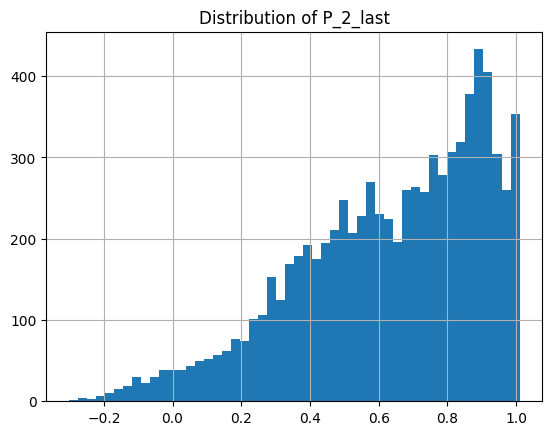

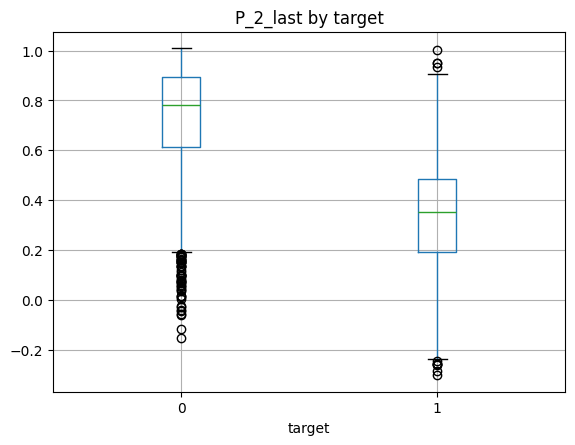


Bottom 10 features with least correlation:
['D_86_last', 'D_86_mean', 'D_86_std', 'D_86_min', 'D_86_max', 'D_86_first', 'D_88_max', 'D_59_delta', 'D_63_delta', 'R_15_delta'] 



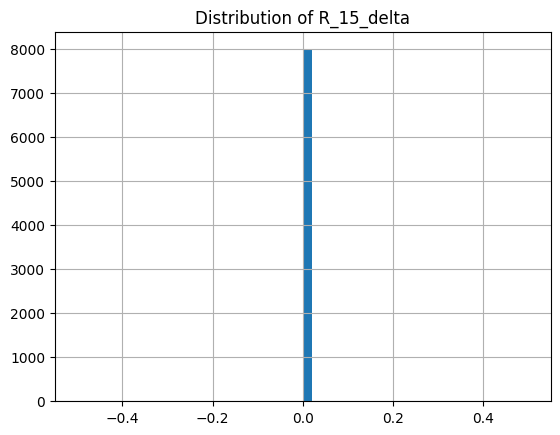

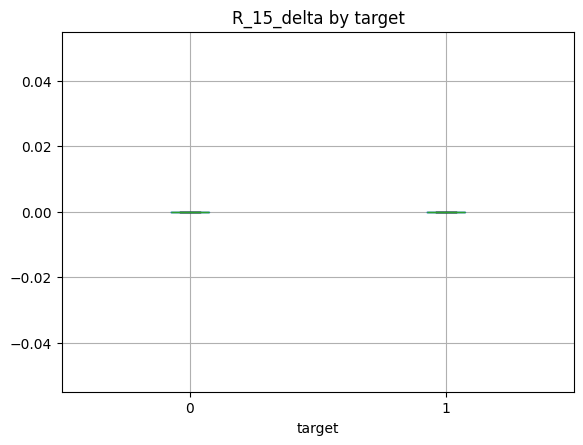

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# Correlation of each featue with target
# ----------------------------------------------------------------------

# dict to store feature names to correlation with y_train
correlations = {}
for col in X_train.columns:
  # Pearson correlation between this feature column and y_train
  correlations[col] = np.corrcoef(X_train[col], y_train)[0, 1]

# Convert dict to series, take absolut value and sort from greatest to least
corr_series = pd.Series(correlations).abs().sort_values(ascending=False)

#Top 20 correlated features
top_features = corr_series.head(20).index.tolist()
#Print first 10 feature names
print("Top 10 features with most correlation:")
print(top_features[:10], "\n")

# ----------------------------------------------------------------------
# Check single most correlated feature
# ----------------------------------------------------------------------

feature = top_features[0]

# Overall distribution, 50 bins on graph
X_train[feature].hist(bins=50)
plt.title(f"Distribution of {feature}")
plt.show()

# Distribution by class
# Create small data frame with feature and target column
tmp = X_train[[feature]].copy()
tmp["target"] = y_train.values

# Boxplot of feature values for target 0 vs target 1
tmp.boxplot(column = feature, by = "target")
plt.title(f"{feature} by target")
plt.suptitle("")
plt.show()

# ----------------------------------------------------------------------
# Check single least correlated feature
# ----------------------------------------------------------------------

#Bottom 20 correlated features
bottom_features = corr_series.tail(20).index.tolist()
#Print first 10 feature names
print("\nBottom 10 features with least correlation:")
print(bottom_features[-10:], "\n")

bot_feature = bottom_features[-1]

# Overall distribution, 50 bins on graph
X_train[bot_feature].hist(bins=50)
plt.title(f"Distribution of {bot_feature}")
plt.show()

# Distribution by class
# Create small data frame with feature and target column
tmp_low = X_train[[bot_feature]].copy()
tmp_low["target"] = y_train.values

# Boxplot of feature values for target 0 vs target 1
tmp_low.boxplot(column = bot_feature, by = "target")
plt.title(f"{bot_feature} by target")
plt.suptitle("")
plt.show()

### **2.5 Correlation heatmap and multicollinearity overview**

The correlation heatmap shown below demonstrates pairwise Pearson correlations for the top 50 features, these are ranked by absolute correlation with default targets. Each cell/square show the strength and direction of the linear relationship between two features. The darkest blue is a value of +1.0, implying that these value have a strong positive correlation. A light white color implies little to no linear relationship between two features. The darkest red is the opposite of the blue, giving a value of -1.0 and a strong negative correlation. In the heatmap, from top left to bottom right diagonally, there is a dark blue line which has a value of +1.0, this mean each feature is perfectly correlated, but it is with itself. Mostly around this line, there are more less darker blue cell/squares. By observing this heatmap, some features are more likely to have a darker blue colors, due to being in the same family of features (e.g. `P_2_*`, `D_48_*`, `B_9_*`, `R_1_*`). This shows that different groups of variables tend to move along side one another, making them positvely correlated.

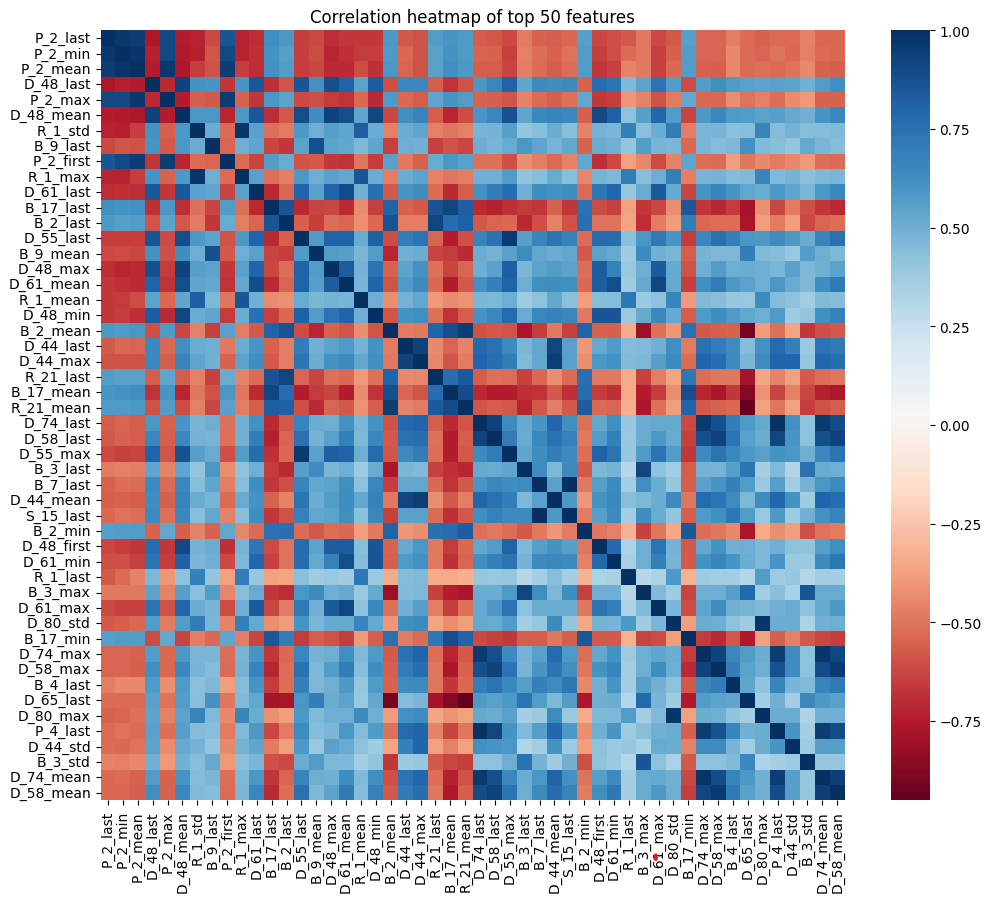

As we go down the list of features, more towards the bottom right area of the heatmap. The blue areas become more bigger, meaning that these features are closely correlated with one another. There are also some red areas, but for modeling the closer to blue or red these features are the more they can imply redudancy with models. Since these features have similar information when closely correlated (even red, which is just an inverse value of one feature to another) they seem more or less repetitive in modeling. The lighter cells/squares, represent close to 0 correlation, which make features behave independently from one another, which can provide more useful complementary information. The heatmaps shows high levels of multicollinearity within the strongest features, which can help with implementing feature selection and/or PCA to get rid of redundent features.

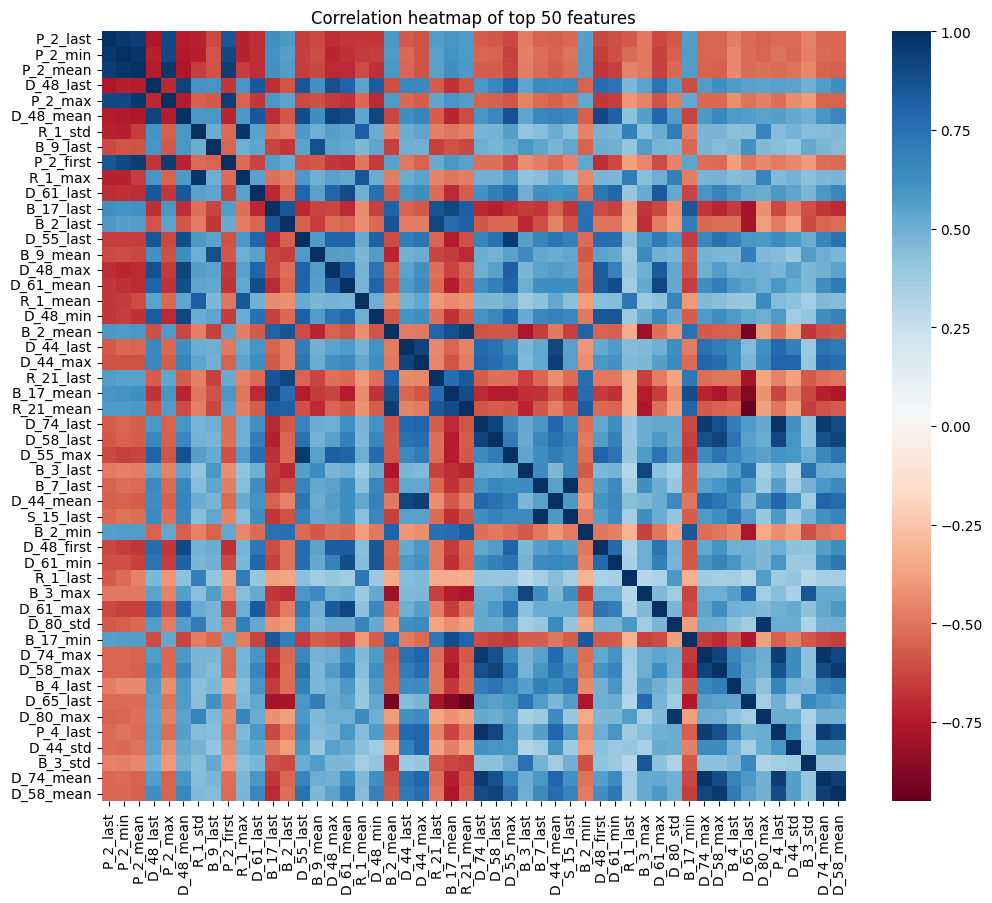

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#-------------------------------
# Correlation heatmap (top n features by absolute correlation)
#-------------------------------

# Use corr_series (which was already computed above in 2.1 - 2.4)
top_n = 50
top_n_features = corr_series.head(top_n).index

# Compute correlation matrix for these features
corr_top = X_train[top_n_features].corr()

plt.figure(figsize = (12, 10))
sns.heatmap(corr_top, cmap = "RdBu", xticklabels = True, yticklabels = True)
plt.title(f"Correlation heatmap of top {top_n} features")
plt.show()

### **2.6 Statistical tests for feature significance (ANOVA F-test)**

After applying the ANOVA F-test `f_classif` on all numeric features (in X-train and y-train), the test gave results based on the mean value between the two groups (non-default and default, 0 and 1 respectively). Which then returned a large `F-value` and very small `p-value`. The larger the f-value is and the smaller the p-value is, goes to show that the feature's distribution is significantly different between the non-defaulters and the defaulters.

The sorted ANOVA results show some top features have pretty high f-values in the thousands, and very small p-values close to 0. This test also proves that the features have strong classification when it comes to marking customers as defaulters and non-defaulters, just like the correlation analysis (in 2.1-2.4, and 2.5) from earlier subsections. Also, features at the bottom of these list show that they don't have much statistically significant seperation between the two class targets.

In [ ]:
from sklearn.feature_selection import f_classif
import pandas as pd
import numpy as np

# ----------------------------------------------------------------------
# Stats test (ANOVA F-test)
# ----------------------------------------------------------------------

#X_train is already numeric, we can use directly
F_values, p_values = f_classif(X_train, y_train)

anova_df = pd.DataFrame({"feature": X_train.columns, "F_value": F_values, "p_value": p_values})

#Sorted by p-value (smaller values are more significant)
anova_df_sorted = anova_df.sort_values(by = "p_value")

print("Top 50 features by ANOVA F-test (lowest p-values):\n")
print(anova_df_sorted.head(50))

anova_df_sorted.to_csv("processed_amex_10k/anova_feature_significance.csv", index = False)

Top 50 features by ANOVA F-test (lowest p-values):

         feature      F_value  p_value
0       P_2_last  6478.789767      0.0
1       P_2_mean  5338.604448      0.0
3        P_2_min  5597.598520      0.0
28       R_1_max  3589.997758      0.0
25      R_1_mean  3035.762331      0.0
26       R_1_std  3732.243780      0.0
24      R_1_last  2340.670559      0.0
60     D_44_last  2923.803641      0.0
66      B_4_last  2167.741411      0.0
61     D_44_mean  2379.601776      0.0
62      D_44_std  2103.305493      0.0
64      D_44_max  2840.114580      0.0
86       R_2_std  1961.967756      0.0
88       R_2_max  1963.936684      0.0
4        P_2_max  4459.949781      0.0
5      P_2_first  3648.732224      0.0
696    R_21_last  2824.012470      0.0
44       B_3_std  2083.000644      0.0
43      B_3_mean  1780.701967      0.0
42      B_3_last  2543.916093      0.0
84      R_2_last  1695.169924      0.0
121     B_7_mean  1846.914113      0.0
490     B_26_max  1837.364133      0.0
107   D_48_f

## **3. Feature Engineering Based on EDA**

### **3.1 New feature construction**

In the ANOVA F-test section (2.6) we saw a list of the top features with lowest p-values at the top, and F-values for said features was in the thousands. Some feature families that stood out were `P_2_*`, `R_1_*`, `D_44_*`, `R_2_*`, and `B_3_*`, these were in the majority of the top 20 on this list. Since these stood out among the rest, I decided to create more features based on these families (around 11 new features)

Some of the new features are the following:

* In the **`P_2_*`**, there are **`P_2_last_vs_mean`**, **`P_2_range`** (max - min), and **`P_2_last_log`**

* In the **`R_1_*`**, there are **`R_1_volatility`** (std over mean) and **`R_1_max_vs_mean`**

* In the **`D_44_*`**, there are **`D_44_range`** (max - min) and **`D_44_last_vs_mean`**

* In the **`R_2_*`**, there are **`R_2_volatility`** (std over mean) and **`R_2_max_vs_mean`**

* In the **`B_3_*`**, there are **`B_3_volatility`** (std over mean) and **`B_3_last_vs_mean`**

These new features provide more variability and deviation in the high feature families that were discovered in EDA and ANOVA.


In [ ]:
import numpy as np

# ------------------------------------------------
# New feature construction, feature families
# at top 20 of the list of ANOVA F-test
# ------------------------------------------------

X_train_fe = X_train.copy()
X_valid_fe = X_valid.copy()

# ----- P_2_* family -----
# Last vs mean
X_train_fe["P_2_last_vs_mean"] = X_train_fe["P_2_last"] / (X_train_fe["P_2_mean"] + 1e-10)
X_valid_fe["P_2_last_vs_mean"] = X_valid_fe["P_2_last"] / (X_valid_fe["P_2_mean"] + 1e-10)

# Range (volatility) max - min
X_train_fe["P_2_range"] = X_train_fe["P_2_max"] - X_train_fe["P_2_min"]
X_valid_fe["P_2_range"] = X_valid_fe["P_2_max"] - X_valid_fe["P_2_min"]

# Log transform to reduce the skewness
X_train_fe["P_2__last_log"] = np.log1p(X_train_fe["P_2_last"].clip(lower = 0))
X_valid_fe["P_2__last_log"] = np.log1p(X_valid_fe["P_2_last"].clip(lower = 0))

# ----- R_1_* familiy -----
# Relative volatility, how large is std vs mean
X_train_fe["R_1_volatility"] = X_train_fe["R_1_std"] / (X_train_fe["R_1_mean"].abs() + 1e-10)
X_valid_fe["R_1_volatility"] = X_valid_fe["R_1_std"] / (X_valid_fe["R_1_mean"].abs() + 1e-10)

# Max vs mean
X_train_fe["R_1_max_vs_mean"] = X_train_fe["R_1_max"] / (X_train_fe["R_1_mean"].abs() + 1e-10)
X_valid_fe["R_1_max_vs_mean"] = X_valid_fe["R_1_max"] / (X_valid_fe["R_1_mean"].abs() + 1e-10)

# ----- D_44_* familiy -----
# Range (volatility) max - min
X_train_fe["D_44_range"] = X_train_fe["D_44_max"] - X_train_fe["D_44_min"]
X_valid_fe["D_44_range"] = X_valid_fe["D_44_max"] - X_valid_fe["D_44_min"]

# Last vs mean
X_train_fe["D_44_last_vs_mean"] = X_train_fe["D_44_last"] / (X_train_fe["D_44_mean"].abs() + 1e-10)
X_valid_fe["D_44_last_vs_mean"] = X_valid_fe["D_44_last"] / (X_valid_fe["D_44_mean"].abs() + 1e-10)

# ----- R_2_* family -----
# Relative volatility, how large is std vs mean
X_train_fe["R_2_volatility"] = X_train_fe["R_2_std"] / (X_train_fe["R_2_mean"].abs() + 1e-10)
X_valid_fe["R_2_volatility"] = X_valid_fe["R_2_std"] / (X_valid_fe["R_2_mean"].abs() + 1e-10)

# Max vs mean
X_train_fe["R_2_max_vs_mean"] = X_train_fe["R_2_max"] / (X_train_fe["R_2_mean"].abs() + 1e-10)
X_valid_fe["R_2_max_vs_mean"] = X_valid_fe["R_2_max"] / (X_valid_fe["R_2_mean"].abs() + 1e-10)

# ----- B_3_* family -----
# Last vs mean
X_train_fe["B_3_last_vs_mean"] = X_train_fe["B_3_last"] / (X_train_fe["B_3_mean"].abs() + 1e-10)
X_valid_fe["B_3_last_vs_mean"] = X_valid_fe["B_3_last"] / (X_valid_fe["B_3_mean"].abs() + 1e-10)

# Relative volatility, how large is std vs mean
X_train_fe["B_3_volatility"] = X_train_fe["B_3_std"] / (X_train_fe["B_3_mean"].abs() + 1e-10)
X_valid_fe["B_3_volatility"] = X_train_fe["B_3_std"] / (X_train_fe["B_3_mean"].abs() + 1e-10)

print("Original features: ", X_train.shape[1])
print("New features: ", X_train_fe.shape[1])

Original features:  1309
New features:  1320


### **3.2 Low-variance feature removal**

Since some features in the dataset were almost constant (or carried little to no information), it was better to apply a low-variance filter using **`VarianceThreshold`** with a threshold of **`0.01`**. This helped remove features where is was unlikely to find any noticible information on how to distinguish defaulters from non-defaulters and vice-versa. The number of features started from the new dataset with added features, **`1320`** features, then after applying low-variance removal, it dropped to **`940`** features.

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# ------------------------------------------------
# Low-variance feature removal
# ------------------------------------------------

# Remove almost constant columns, uses new dataset with new features
vt = VarianceThreshold(threshold = 0.01)
vt.fit(X_train_fe)

# New dataset with variance filtering (vf)
X_train_vf = X_train_fe.loc[:, vt.get_support()]
X_valid_vf = X_valid_fe.loc[:, vt.get_support()]

print("New features (from 3.1): ", X_train_fe.shape[1])
print("After variance filtering: ", X_train_vf.shape[1])

New features (from 3.1):  1320
After variance filtering:  940


### **3.3 Reducing redundancy with feature-based pruning**

Just like variance-filtering with the dataset, I also applied correlation-filtering with features that had to high of a absolute correlation value. Anything with a value of **`0.95`** or over, gets dropped from the dataset. Since any feature with a number higher than the threshold does not provide much use in modeling, due to multicollinearity. To avoid any issues with duplicates when turning the dataset into a matrix (e.g. pairs like `i, j` and `j, i`), we take the upper traingle of the matrix and work from there. Then we create a list to see which pairs have a correlation value above the threshold, once identified they are added to the list. After that we create a new dataset, but we apply the drop list and remove those features. This resulted with the after variance-filtering dataset, of **`940`** features, to drop to **`742`** features for the after correlation-filtering dataset.

In [ ]:
import numpy as np

# ------------------------------------------------
# Correlation-based pruning (multicollinearity reduction)
# ------------------------------------------------

# Compute abs correlation matrix on new variance-filtered feature dataset
corr_matrix = X_train_vf.corr().abs()

# Take only upper triangle (helps avoid duplicate pairing, e.g. i,j and j,i)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))

# Threshold for "high correlated features"
# Number can be tweaked, to see if future modeling improves
# Don't go over 1.
corr_thres = 0.95

# List of columns with correlation with other features above threshold to drop, |corr| > corr_thres
drop = [col for col in upper_tri.columns if any(upper_tri[col] > corr_thres)]

print("Features with high correlation to drop: ", len(drop))

# New datasets after correlation-filtering (cf)
X_train_cf = X_train_vf.drop(columns = drop)
X_valid_cf = X_valid_vf.drop(columns = drop)

print("After variance-filtering: ", X_train_vf.shape[1])
print("After correlation-filtering: ", X_train_cf.shape[1])

Features with high correlation to drop:  198
After variance-filtering:  940
After correlation-filtering:  742


### **3.4 Dimensionality reduction with PCA on selected features**

When applying PCA initially, some exceptions were hit do to NaN values found in dataset, that were caused by the filtering previously done to the datasets. So, these values were replaced and imputed with the median. This allows PCA to work since the datasets now has none NaN values and only finite values.

After all the filtering that was done on the data, there are still hundreds of features. Applying PCA to the standardized feature matrix allows the data to become more condensed/compact and orthogonal. PCA helps create new uncorrelated components that help provide main directions of variation for the data. We took the first 50 principal components, which compress the **`742-dim`** features space into a much smaller set. This gave a variance of **`57.74%`** from the training data. This can help give the modeling members (Members 3 and 4) a low-dimensional alternative input, which can also be used alongside some selected features when it comes to training their models.

In [ ]:
import numpy as np
import pandas as pd

# ------------------------------------
# Clean inf and NaN
# ------------------------------------

X_train_cf = X_train_cf.replace([np.inf, -np.inf], np.nan)
X_valid_cf = X_valid_cf.replace([np.inf, -np.inf], np.nan)

# Checks NaNs in datasets
print("NaNs in X_train_cf: ", X_train_cf.isna().sum().sum())
print("NaNs in X_valid_cf: ", X_valid_cf.isna().sum().sum())

NaNs in X_train_cf:  0
NaNs in X_valid_cf:  2000


In [ ]:
from sklearn.impute import SimpleImputer

# ------------------------------------------------
# Impute missing values
# ------------------------------------------------

# Impute missing values with median
imputer = SimpleImputer(strategy = "median")
X_train_cf_imp = pd.DataFrame(imputer.fit_transform(X_train_cf), columns = X_train_cf.columns, index = X_train_cf.index)
X_valid_cf_imp = pd.DataFrame(imputer.transform(X_valid_cf), columns = X_valid_cf.columns, index = X_valid_cf.index)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ------------------------------------------------
# Dim reduction with PCA
# ------------------------------------------------

# Standardize the features before PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cf_imp)
X_valid_scaled = scaler.transform(X_valid_cf_imp)

# Fit PCA, in this case we keep the first 50 components
pca = PCA(n_components = 50)
X_train_pca = pca.fit_transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)

print("After correlation-filtering: ", X_train_cf_imp.shape[1])
print("After PCA: ", X_train_pca.shape[1])
print("Total variance detailed by 50 PCs: ", pca.explained_variance_ratio_.sum())


After correlation-filtering:  742
After PCA:  50
Total variance detailed by 50 PCs:  0.5774188083076423


### **3.5 Final feature matrices and code reproducibility**

After adding the new features (11 new features), low-variance filtering, correlation pruning (correlation-filtering), and PCA (with imputer). Two final representation of the data were produced for use for the modeling members (Member 3 and 4). The first dataset (training and validation) is **selected feature matrix**, which contains **`742`** features for each **`8,000`** and **`2,000`** customers. The second dataset (training and validation) is **PCA representation**, which is the first **`50`** principal components. This gives a more condensed/compact, orthoganl insert of the same data. Both of these versions are located in processed_amex_10k folders. With the first dataset being:
* **`processed_amex_10k/X_train_mem2_selected.parquet`** and **`processed_amex_10k/X_valid_mem2_selected.parquet`**.

The second (or PCA representation) being:
*  **`processed_amex_10k/X_train_mem2_pca.npy`** and **`processed_amex_10k/X_valid_mem2_pca.npy`**.

In the same folder are the fitted imputer, scaler and PCA objects:
* **`imputer.joblib`**
* **`pca.joblib`**
* **`scaler.joblib`**

In [ ]:
import numpy as np
import joblib

# --------------------------------------
# Save final feature matrices and transformers
# --------------------------------------

# Selected (non-PCA) feature matrices after all filters (and imputation)
X_train_cf_imp.to_parquet("processed_amex_10k/X_train_mem2_selected.parquet", index = False)
X_valid_cf_imp.to_parquet("processed_amex_10k/X_valid_mem2_selected.parquet", index = False)

# PCA (50 components)
np.save("processed_amex_10k/X_train_mem2_pca.npy", X_train_pca)
np.save("processed_amex_10k/X_valid_mem2_pca.npy", X_valid_pca)

# Save preprocessing objects so they can be reused with problems
joblib.dump(imputer, "processed_amex_10k/imputer.joblib")
joblib.dump(scaler, "processed_amex_10k/scaler.joblib")
joblib.dump(pca, "processed_amex_10k/pca.joblib")

print("Saved selected features, PCA features, and transformers")

Saved selected features, PCA features, and transformers


# **Member 3: Model Implementation: Logistic Regression, Random Forest (Nathan Morales)**


As member 3, my role for this project was implementing the baseline models of Logistic Regression and Random Forest which included fixed hyperparameters on each to easily facilitate with its execution time.

In [ ]:
# ===============================
#   MODELING: Logistic Regression + Random Forest
# ===============================

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# METRICS IMPORT
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# ===============================
# Load preprocessed data given from member1
# ===============================

X_train = pd.read_parquet("processed_amex_10k/X_train_mem2_selected.parquet")
X_valid = pd.read_parquet("processed_amex_10k/X_valid_mem2_selected.parquet")

y_train = pd.read_csv("processed_amex_10k/y_train.csv")["target"]
y_valid = pd.read_csv("processed_amex_10k/y_valid.csv")["target"]

print("Data loaded:")
print(" X_train:", X_train.shape)
print(" X_valid:", X_valid.shape)


# ===============================
# Logistic Regression Model
# ===============================

print("\n===== Logistic Regression =====")

log_reg = LogisticRegression(
    max_iter=500,
    n_jobs=-1
)

log_reg.fit(X_train, y_train)

lr_preds = log_reg.predict(X_valid)
lr_probs = log_reg.predict_proba(X_valid)[:, 1]

print("Accuracy:", accuracy_score(y_valid, lr_preds))
print("Precision:", precision_score(y_valid, lr_preds))
print("Recall:", recall_score(y_valid, lr_preds))
print("F1 Score:", f1_score(y_valid, lr_preds))
print("ROC-AUC:", roc_auc_score(y_valid, lr_probs))
print("Confusion Matrix:\n", confusion_matrix(y_valid, lr_preds))


# ===============================
# Random Forest Model
# ===============================

print("\n===== Random Forest =====")

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

rf_preds = rf.predict(X_valid)
rf_probs = rf.predict_proba(X_valid)[:, 1]

print("Accuracy:", accuracy_score(y_valid, rf_preds))
print("Precision:", precision_score(y_valid, rf_preds))
print("Recall:", recall_score(y_valid, rf_preds))
print("F1 Score:", f1_score(y_valid, rf_preds))
print("ROC-AUC:", roc_auc_score(y_valid, rf_probs))
print("Confusion Matrix:\n", confusion_matrix(y_valid, rf_preds))


Data loaded:
 X_train: (8000, 742)
 X_valid: (2000, 742)

===== Logistic Regression =====
Accuracy: 0.8685
Precision: 0.762278978388998
Recall: 0.7320754716981132
F1 Score: 0.7468719923002888
ROC-AUC: 0.9341342574765756
Confusion Matrix:
 [[1349  121]
 [ 142  388]]

===== Random Forest =====
Accuracy: 0.8755
Precision: 0.7728155339805826
Recall: 0.7509433962264151
F1 Score: 0.7617224880382775
ROC-AUC: 0.9424066230265692
Confusion Matrix:
 [[1353  117]
 [ 132  398]]


Under the data loaded printed section, we can see the shape representation indicating a use of 8000 training samples, 2000 validation samples, and a total of 742 features each. Analyzing the evaluation metrics for both models, it can be noted that the Random Forest model performs better as its accuracy indicates that its slightly above. In addition its also better at avoiding false positives and catching the ones that are true, the confusion matrix also reflects this as the top right corner and bottom left have fewer false positives and fewer false negatives.


In [ ]:
import joblib
import os

# Ensure the models directory exists
# This was already created in cell 1RAbkJLdidzj, but good to be explicit
os.makedirs("models", exist_ok=True)

joblib.dump(rf, os.path.join('models', 'rf_model.pkl'))
joblib.dump(log_reg, os.path.join('models', 'log_reg_model.pkl'))


['models/log_reg_model.pkl']

# **Member 4: Advanced Modeling and Optimization:(Shreya Sridharan)**

As Member 4, my role was to build advanced models on top of the cleaned and feature-engineered data from Members 1 and 2, and to optimize them beyond the baseline Logistic Regression and Random Forest models implemented by Member 3.

In [2]:

import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import(
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
!pip install optuna
import shap

#Path

DATA_DIR = "processed_amex_10k"
os.makedirs("results", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("figures", exist_ok=True)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.5 MB/s eta 0:00:00


Part 2: Loading data from Members 1 and 2:

In [ ]:
#Load from members 1,2

X_train_base = pd.read_parquet(os.path.join(DATA_DIR, "X_train.parquet"))
X_valid_base = pd.read_parquet(os.path.join(DATA_DIR, "X_valid.parquet"))

y_train = pd.read_csv(os.path.join(DATA_DIR, "y_train.csv"))["target"]
y_valid = pd.read_csv(os.path.join(DATA_DIR, "y_valid.csv"))["target"]

X_train_selected = pd.read_parquet(os.path.join(DATA_DIR, "X_train_mem2_selected.parquet"))
X_valid_selected = pd.read_parquet(os.path.join(DATA_DIR, "X_valid_mem2_selected.parquet"))

X_train_pca = np.load(os.path.join(DATA_DIR, "X_train_mem2_pca.npy"))
X_valid_pca = np.load(os.path.join(DATA_DIR, "X_valid_mem2_pca.npy"))

print("base features")
print(" X_train:", X_train_base.shape)
print(" X_valid:", X_valid_base.shape)

print("\nselected features")
print(" X_train:", X_train_selected.shape)
print(" X_valid:", X_valid_selected.shape)

print("\nlabels")
print(" y_train:", y_train.shape)
print(" y_valid:", y_valid.shape)



base features
 X_train: (8000, 1309)
 X_valid: (2000, 1309)

selected features
 X_train: (8000, 742)
 X_valid: (2000, 742)

labels
 y_train: (8000,)
 y_valid: (2000,)


Part 3: Computation and Storage

In [ ]:
def compute_metrics(name, y_true, y_pred, y_prob):
  """Compute standard classification metrics"""
  acc= accuracy_score(y_true, y_pred)
  prec = precision_score(y_true, y_pred)
  rec = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  auc = roc_auc_score(y_true, y_prob)
  cm = confusion_matrix(y_true, y_pred)

  print (f"{name} metrics:")
  print("Accuracy: ", acc)
  print("Precision: ", prec)
  print("Recall: ", rec)
  print("F1 Score: ", f1)
  print("ROC-AUC: ", auc)
  print("Confusion Matrix:\n", cm)

  return{
      "model name": name,
      "accuracy": acc,
      "precision": prec,
      "recall": rec,
      "f1": f1,
      "auc": auc,
      "confusion_matrix": cm
  }
results =[]



Section 4: Loading baseline models from Member 3 to evaluate

In [ ]:
import os

print ("\n=== Evaluating baseline models from member 3 based on base features===")
# Load models from the 'models' directory
log_reg = joblib.load(os.path.join('models', 'log_reg_model.pkl'))
rf = joblib.load(os.path.join('models', 'rf_model.pkl'))

#logistic regression
lr_probs = log_reg.predict_proba(X_valid_selected)[:, 1]
lr_preds = log_reg.predict(X_valid_selected)
results.append(compute_metrics("Logistic Regression", y_valid, lr_preds, lr_probs))

#random forest
rf_probs = rf.predict_proba(X_valid_selected)[:, 1]
rf_preds = rf.predict(X_valid_selected)
results.append(compute_metrics("Random Forest", y_valid, rf_preds, rf_probs))



=== Evaluating baseline models from member 3 based on base features===
Logistic Regression metrics:
Accuracy:  0.8685
Precision:  0.762278978388998
Recall:  0.7320754716981132
F1 Score:  0.7468719923002888
ROC-AUC:  0.9341342574765756
Confusion Matrix:
 [[1349  121]
 [ 142  388]]
Random Forest metrics:
Accuracy:  0.8755
Precision:  0.7728155339805826
Recall:  0.7509433962264151
F1 Score:  0.7617224880382775
ROC-AUC:  0.9424066230265692
Confusion Matrix:
 [[1353  117]
 [ 132  398]]


Section 5: Advanced Models

In [ ]:
#XGBoost with Optuna based on Member 2 selection


pos_ratio = y_train.sum()/len(y_train)
scale_pos_weight = (1-pos_ratio)/pos_ratio

def objective_xgb(trial):
  params ={
      "n_estimators": trial.suggest_int("n_estimators", 200,500),
      "max_depth": trial.suggest_int("max_depth", 3,8),
      "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
      "subsample": trial.suggest_float("subsample", 0.6, 1.0),
      "colsample_bytree": trial.suggest_float ("colsample_bytree", 0.6, 1.0),
      "min_child_weight": trial.suggest_int("min_child_weight", 1, 6),
      "gamma": trial.suggest_float("gamma", 0.0, 5.0),
      "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
      "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
      "objective": "binary:logistic",
      "eval_metric": "logloss",
      "n_jobs": -1,
      "random_state": 42,
      "scale_pos_weight": scale_pos_weight
  }

  model = XGBClassifier(**params)
  cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
  scores = []

  for train_idx, val_idx in cv.split(X_train_selected, y_train):
    X_train_fold, X_val_fold = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model.fit(X_train_fold, y_train_fold)
    probs = model.predict_proba(X_val_fold)[:, 1]
    scores.append(roc_auc_score( y_val_fold, probs))

  return np.mean(scores)

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=20, show_progress_bar=False)

print("Best XGB params: ", study_xgb.best_params)
print("Best XGB CV ROC_AUC: ",study_xgb.best_value)

xgb_best = XGBClassifier(
    **study_xgb.best_params,
    objective = "binary:logistic",
    eval_metric = "logloss",
    n_jobs = -1,
    random_state=42,
    scale_pos_weight = scale_pos_weight
)
xgb_best.fit(X_train_selected, y_train)
xgb_probs = xgb_best.predict_proba(X_valid_selected)[:, 1]
xgb_preds = (xgb_probs >= 0.5).astype(int)
results.append(compute_metrics("XGBoost", y_valid, xgb_preds, xgb_probs))
joblib.dump(xgb_best, "xgb_best_model.pkl")


[I 2025-12-11 18:03:28,641] A new study created in memory with name: no-name-99d348fa-712f-4959-8b85-8f43b8ad1a38
[I 2025-12-11 18:05:06,177] Trial 0 finished with value: 0.9523787838128636 and parameters: {'n_estimators': 342, 'max_depth': 4, 'learning_rate': 0.04066521542266215, 'subsample': 0.9413344271223374, 'colsample_bytree': 0.9024494256544885, 'min_child_weight': 3, 'gamma': 4.517879414404698, 'reg_lambda': 0.043508700032318104, 'reg_alpha': 2.651387470408304}. Best is trial 0 with value: 0.9523787838128636.
[I 2025-12-11 18:06:16,278] Trial 1 finished with value: 0.9519015180016474 and parameters: {'n_estimators': 355, 'max_depth': 4, 'learning_rate': 0.03850463663096414, 'subsample': 0.7603684362450338, 'colsample_bytree': 0.7818269543628411, 'min_child_weight': 3, 'gamma': 0.5654447455489298, 'reg_lambda': 0.27910718885208907, 'reg_alpha': 4.264946011678802}. Best is trial 0 with value: 0.9523787838128636.
[I 2025-12-11 18:06:50,907] Trial 2 finished with value: 0.952000264

Tuning the threshhold for the best F1 using XGB

In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np

print ("\n=== tuning the threshhold for the best F1 using XGB ===")
precisions, recalls, thresholds = precision_recall_curve(y_valid, xgb_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print ("Best threshold for F1: ", best_threshold)
print ("Precision at best F1: ", precisions[best_idx])
print ("Recall at best F1: ", recalls[best_idx])
print ("F1 score at best F1: ", f1_scores[best_idx])

xgb_preds = (xgb_probs >= best_threshold).astype(int)
results.append(compute_metrics("XGB_tuned_selected_customeThresh", y_valid, xgb_preds, xgb_probs))



=== tuning the threshhold for the best F1 using XGB ===


NameError: name 'precision_recall_curve' is not defined

Feature Importance Plots

In [ ]:
def plot_feature_importance(model, feature_names, top_n = 25, title="Feature Importance", filename = "feature_importance.png"):
  importance = model.feature_importances_
  print(feature_names,importance)
  imp_df = pd.DataFrame({
      "feature": feature_names,
      "importance": importance
  }).sort_values(by="importance", ascending=False)

  plt.figure(figsize=(10, 10))
  sns.barplot(x="importance", y="feature", data=imp_df.head(top_n))
  plt.title(title)
  plt.tight_layout()
  plt.savefig(os.path.join("figures", filename))
  plt.close()

plot_feature_importance(
    xgb_best,
    X_train_selected.columns,
    title="XGBoost Feature Importance",
    filename="xgb_feature_importance_top30.png")





NameError: name 'xgb_best' is not defined

SHAP analysis

In [ ]:
#on XGB

print ("\n=== SHAP analysis on XGB ===")
sample_size = min(1000, X_train_selected.shape[0])
X_sample = X_train_selected.sample(sample_size, random_state=42)
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(X_sample)

plt.figure()
shap.summary_plot(
    shap_values,
    X_sample,
    plot_type="bar",
    show=False
)

plt.tight_layout()
plt.savefig(os.path.join("figures", "xgb_shap_summary_bar.png"))
plt.close()

plt.figure()
shap.summary_plot(
    shap_values,
    X_sample,
    show=False
)

plt.tight_layout()
plt.savefig(os.path.join("figures", "xgb_shap_summary.png"))
plt.close()

print("Saved SHAP plots to 'figures/' folder. ")


=== SHAP analysis on XGB ===
Saved SHAP plots to 'figures/' folder. 


Model performance (Leaderboard)

In [ ]:
results_df = pd.DataFrame(results).sort_values("auc", ascending=False)
print("\nModel Performance (Leaderboard):")
print(results_df)

results_df.to_csv(os.path.join("results", "model_performance.csv"), index=False)
print("\nSaved model performance leaderboard to 'results/model_performance_leaderboard.csv'")


Model Performance (Leaderboard):
                         model name  accuracy  precision    recall        f1  \
3  XGB_tuned_selected_customeThresh    0.8735   0.718110  0.860377  0.782833   
2                           XGBoost    0.8705   0.716800  0.845283  0.775758   
1                     Random Forest    0.8755   0.772816  0.750943  0.761722   
0               Logistic Regression    0.8685   0.762279  0.732075  0.746872   

        auc           confusion_matrix  
3  0.945459   [[1291, 179], [74, 456]]  
2  0.945459   [[1293, 177], [82, 448]]  
1  0.942407  [[1353, 117], [132, 398]]  
0  0.934134  [[1349, 121], [142, 388]]  

Saved model performance leaderboard to 'results/model_performance_leaderboard.csv'


Member 5 - Jackson Scott: Evaluation, Visualization, and Documentation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

stats = pd.read_csv("/content/model_performance.csv")

Plot the ROC curve and AUC value

In [4]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_valid, xgb_probs)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess') # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall/Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()

NameError: name 'y_valid' is not defined

Load final model table, Plot the model preformance in Recall

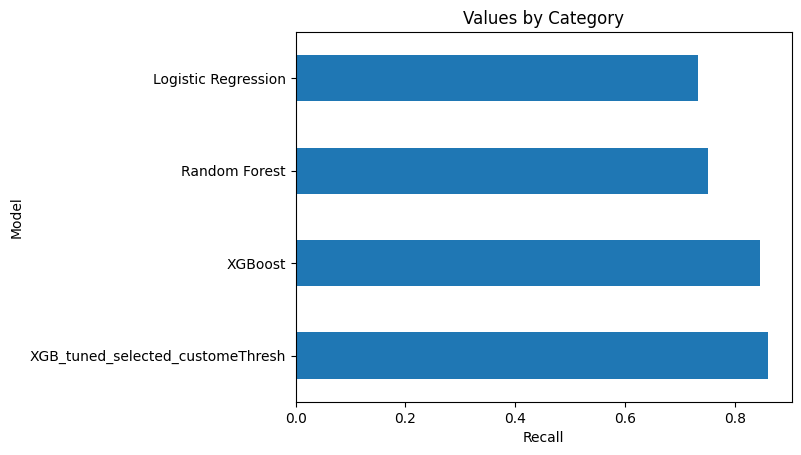

,model name,accuracy,precision,recall,f1,auc,confusion_matrix
0,XGB_tuned_selected_customeThresh,0.8735,0.718110,0.860377,0.782833,0.945459,[[1291 179]\n [ 74 456]]
1,XGBoost,0.8705,0.716800,0.845283,0.775758,0.945459,[[1293 177]\n [ 82 448]]
2,Random Forest,0.8755,0.772816,0.750943,0.761722,0.942407,[[1353 117]\n [ 132 398]]
3,Logistic Regression,0.8685,0.762279,0.732075,0.746872,0.934134,[[1349 121]\n [ 142 388]]


from matplotlib import pyplot as plt
stats['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
stats['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
stats['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
stats['f1'].plot(kind='hist', bins=20, title='f1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
stats.groupby('model name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
stats.groupby('confusion_matrix').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
stats.plot(kind='scatter', x='accuracy', y='precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
stats.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
stats.plot(kind='scatter', x='recall', y='f1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
stats.plot(kind='scatter', x='f1', y='auc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
stats['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
stats['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
stats['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
stats['f1'].plot(kind='line', figsize=(8, 4), title='f1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['confusion_matrix'].value_counts()
    for x_label, grp in stats.groupby('model name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('model name')
_ = plt.ylabel('confusion_matrix')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(stats['model name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(stats, x='accuracy', y='model name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(stats['confusion_matrix'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(stats, x='accuracy', y='confusion_matrix', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(stats['model name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(stats, x='precision', y='model name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(stats['confusion_matrix'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(stats, x='precision', y='confusion_matrix', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [19]:
ax = stats.plot(kind='barh', y='recall', x='model name', legend=False)
plt.title('Values by Category')
plt.ylabel('Model')
plt.xlabel('Recall')
plt.show()

stats